# Santander Customer Transaction Prediction

## Best Practices
- Always set random seed for any non-deterministic algo/function for reproducibility.
- Always split data to train, test, valid sets before applying any data transformations.
- For transformations, fit on train set, and perform transform on valid/test sets.

In [1]:
RANDOM_STATE = 42

## Download Dataset

In [2]:
# You must accept this competition's rules before you'll be able to download files.
# https://www.kaggle.com/c/santander-customer-transaction-prediction/data

# !kaggle competitions download -c santander-customer-transaction-prediction
# !unzip ./notebooks/santander-customer-transaction-prediction.zip -d ../data



## Imports

In [3]:
import numpy as np
import pandas as pd

pd.options.plotting.backend = "plotly"

In [4]:
import missingno as msno

# import pandas_profiling as pf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from pathlib import Path

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    # confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
)

## Loading Dataset

In [6]:
csv_path = "../data/train.csv"
df = pd.read_csv(csv_path)
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


## Basic EDA

In [7]:
# check complete df shape
print(df.shape)

(200000, 202)


In [8]:
# check target variable counts
print(df["target"].value_counts())

target
0    179902
1     20098
Name: count, dtype: int64


In [9]:
# check data types
print(df.dtypes)

ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
            ...   
var_195    float64
var_196    float64
var_197    float64
var_198    float64
var_199    float64
Length: 202, dtype: object


In [10]:
# check missing values

display(df.isna().sum())

display(df.info())

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


None

In [11]:
df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [13]:
# duplicate id check
print(df["ID_code"].nunique())

200000


## Data Split
Before performing any data manipulation to base data, we'll split data into train, test and valid sets. 

This is done to prevent train data leakage to test/dev which may give false sense of security when evaluating model.

In [14]:
train_df, test_df = train_test_split(
    df,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=df["target"],
)
test_df, valid_df = train_test_split(
    test_df,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=test_df["target"],
)

for df_ in [train_df, valid_df, test_df]:
    print(df_.shape)
    print(df_["target"].value_counts())

(140000, 202)
target
0    125931
1     14069
Name: count, dtype: int64
(30000, 202)
target
0    26986
1     3014
Name: count, dtype: int64
(30000, 202)
target
0    26985
1     3015
Name: count, dtype: int64


In [15]:
train_df.shape

(140000, 202)

In [16]:
def split_to_feature_target(df: pd.DataFrame):
    X = df.copy()

    # remove unique attribute
    X.pop("ID_code")
    y = X.pop("target")

    return X, y

In [17]:
train_X, train_y = split_to_feature_target(train_df)

train_X.shape, train_y.shape

((140000, 200), (140000,))

In [18]:
# export a simple imputer to impute missing values in production
import pickle as pkl
from sklearn.impute import SimpleImputer


imputer = SimpleImputer()
imputer.fit(train_X)

with open("./simple_imputer.pkl", "wb") as f:
    pkl.dump(imputer, f)

In [19]:
train_X.columns

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

## Possible Curse of Dimensionality 

One of the issue here is large number of input features, so we need to find some way to reduce the number of features to a managable count. This will speed up the training and also remove noisy/unimportant features.

Some ways to reduce num features - 
- Remove highly correlated independent features
- PCA (with different degree of variance) 
<!-- - Use Random Forest to estimate feature importance -->

### Correlation Matrix

In [20]:
# checking correlation among features
corr_mat = np.round(train_X.corr(), 3)
corr_mat

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
var_0,1.000,-0.001,0.008,0.002,0.002,0.004,0.008,0.005,0.005,-0.005,...,0.002,0.000,-0.006,0.001,-0.002,0.003,0.003,-0.001,-0.006,0.003
var_1,-0.001,1.000,0.001,-0.002,0.002,-0.001,0.003,0.002,0.002,0.001,...,0.006,0.005,-0.003,0.002,-0.004,-0.002,-0.002,-0.005,-0.004,0.004
var_2,0.008,0.001,1.000,0.002,0.000,0.000,0.001,-0.002,0.002,-0.003,...,0.003,0.001,-0.005,0.003,0.003,-0.001,0.005,0.000,-0.000,0.002
var_3,0.002,-0.002,0.002,1.000,-0.001,0.004,0.000,0.001,0.002,0.000,...,-0.000,0.003,-0.002,0.001,-0.000,-0.001,0.001,0.003,-0.003,0.001
var_4,0.002,0.002,0.000,-0.001,1.000,-0.001,-0.001,0.004,-0.000,-0.000,...,0.002,0.003,0.003,0.002,-0.000,0.003,0.001,0.001,0.002,-0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.003,-0.002,-0.001,-0.001,0.003,-0.002,0.002,0.001,0.001,-0.002,...,0.006,-0.001,-0.005,-0.001,0.002,1.000,0.001,-0.006,-0.001,0.003
var_196,0.003,-0.002,0.005,0.001,0.001,0.003,0.004,0.000,-0.004,0.002,...,0.000,0.001,-0.001,-0.004,-0.007,0.001,1.000,-0.002,-0.001,0.000
var_197,-0.001,-0.005,0.000,0.003,0.001,0.000,-0.004,0.005,-0.005,0.005,...,-0.004,0.002,-0.000,0.004,-0.001,-0.006,-0.002,1.000,0.001,0.004
var_198,-0.006,-0.004,-0.000,-0.003,0.002,-0.001,-0.002,0.001,0.001,0.003,...,-0.001,0.000,0.002,0.002,0.004,-0.001,-0.001,0.001,1.000,-0.006


In [21]:
# checking if any 2 features have more than 70% correlation
tmp = corr_mat.copy()
np.fill_diagonal(tmp.values, 0)
(tmp > 0.7).sum().sum()

# Nope, features are NOT highly correlated

0

### PCA

In [22]:
# reducing dimension to retain 90% varaince in dataset
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
train_X_9var = pca.fit_transform(train_X)
train_X_9var.shape

(140000, 90)

In [23]:
def classification_metrics(model, X, y):
    preds = model.predict(X)
    accuracy = accuracy_score(y, preds)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    f1 = f1_score(y, preds)
    print(f"Accuracy - {accuracy}")
    print(f"Precision - {precision}")
    print(f"Recall - {recall}")
    print(f"F1-score - {f1}")
    plt.rc("font", size=9)  # extra code – make the text smaller
    ConfusionMatrixDisplay.from_predictions(y, preds)
    plt.show()
    print(classification_report(y, preds))
    probs = model.predict_proba(X)[:, 1]
    print(f"ROC AUC Score (Primary Objective) - {roc_auc_score(y, probs)}")
    RocCurveDisplay.from_estimator(model, X, y)
    plt.show()

Okay, so now we have 2 variation of datasets - Original data with 200 features and PCA reduced Data with 90% varaiance capture and 90 features.

<!-- We also a possible feature importance score of all features, though it may not be reliable since model has clearly overfitted and may have captured noise in feature importance -->

To start with, we'll first train model on raw data, then proceed with PCA version if score on leader board is less than `70%`.

PS - Aiming for atleast 0.7 score on leader board, since objective is to demonstrate model development skills and not achieving high score. 

## Model Training

We'll start with basic classification models on original dataset, described below - 
- Scaling + Logistic Regression
- Scaling + LinearSVC or SVC (support vector classifier)
<!-- - Random Forest (feature scaling not required) -->


Finally, we'll tune hyperparameters of these models using GridSearchCV or RandomSearchCV

### Scaled data + Logistic Regression

In [24]:
# MinMaxScaler, StandardScaler
mm_scaler = MinMaxScaler()

train_X_scaled = mm_scaler.fit_transform(train_X)
# sanity check
train_X.shape, train_X_scaled.shape


((140000, 200), (140000, 200))

In [25]:
lr_clf = LogisticRegression()
lr_clf.fit(train_X_scaled, train_y)


LogisticRegression()

#### Evaluation of Logistic Regression
Since dataset is highly skewed, we'll only consider precision, recall, f1-score.

Accuracy won't mean much in such dataset where if model predicts only majority class, attain good accuracy.

Also the model is evaluated based on <ins>ROC AUC</ins>, this will be our primary metric for optimization.

In [26]:
valid_X, valid_y = split_to_feature_target(valid_df)
test_X, test_y = split_to_feature_target(test_df)


Classification metrics for Train dataset -
Accuracy - 0.9151285714285714
Precision - 0.6971335857220119
Recall - 0.27485962044210677
F1-score - 0.3942699836867863


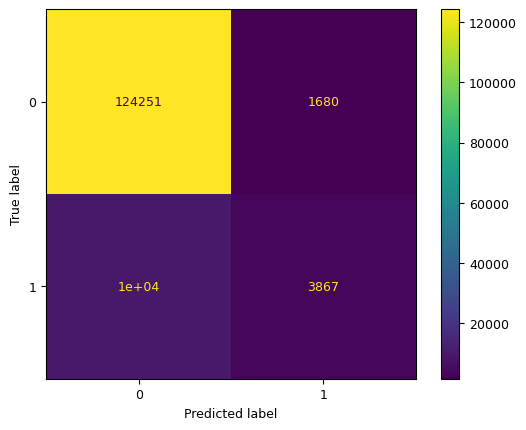

              precision    recall  f1-score   support

           0       0.92      0.99      0.95    125931
           1       0.70      0.27      0.39     14069

    accuracy                           0.92    140000
   macro avg       0.81      0.63      0.67    140000
weighted avg       0.90      0.92      0.90    140000

ROC AUC Score (Primary Objective) - 0.8618443193542149


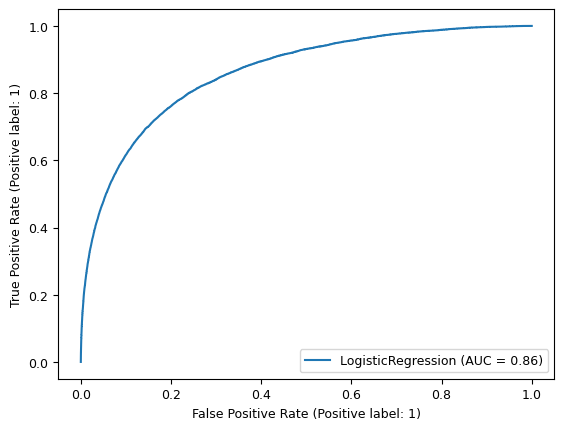

Classification metrics for Valid dataset -
Accuracy - 0.9132666666666667
Precision - 0.6705298013245033
Recall - 0.26874585268745854
F1-score - 0.3837044054950261


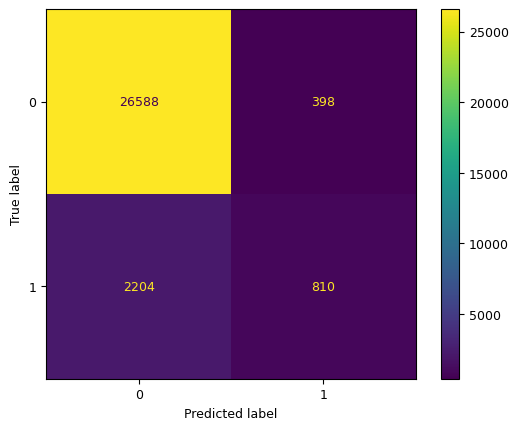

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     26986
           1       0.67      0.27      0.38      3014

    accuracy                           0.91     30000
   macro avg       0.80      0.63      0.67     30000
weighted avg       0.90      0.91      0.90     30000

ROC AUC Score (Primary Objective) - 0.8608088265777762


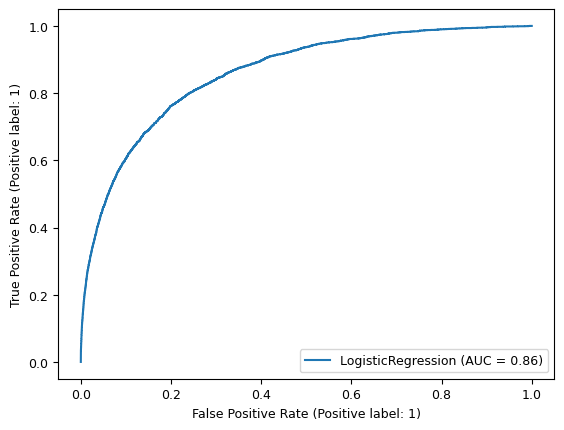

Classification metrics for Test dataset -
Accuracy - 0.9137666666666666
Precision - 0.6887125220458554
Recall - 0.25903814262023217
F1-score - 0.3764762593395999


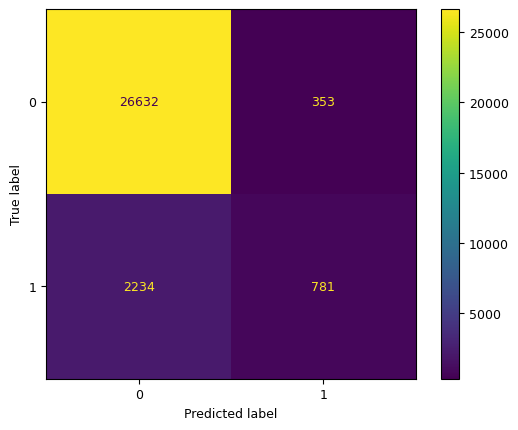

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     26985
           1       0.69      0.26      0.38      3015

    accuracy                           0.91     30000
   macro avg       0.81      0.62      0.67     30000
weighted avg       0.90      0.91      0.90     30000

ROC AUC Score (Primary Objective) - 0.856890803840104


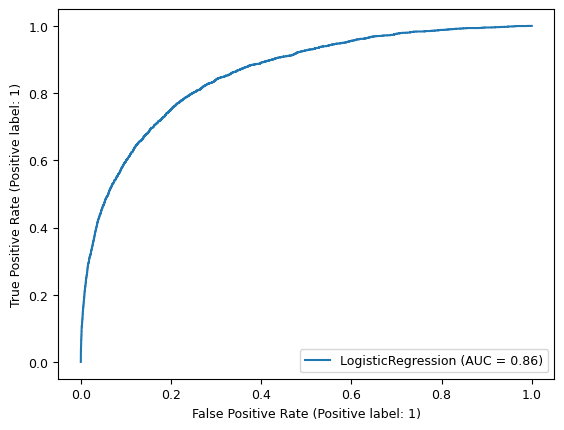

In [27]:
print("Classification metrics for Train dataset -")
classification_metrics(lr_clf, train_X_scaled, train_y)

print("Classification metrics for Valid dataset -")
classification_metrics(lr_clf, mm_scaler.transform(valid_X), valid_y)

print("Classification metrics for Test dataset -")
classification_metrics(lr_clf, mm_scaler.transform(test_X), test_y)


Model has poor precision and recall, but decent ROC.

Lets try GridSearch to check if we can have better performance.

In [28]:
param_grid = [
    {
        "lr__class_weight": ["balanced"],
        "lr__max_iter": [100, 250, 500],
        "lr__n_jobs": [-1],
        "lr__C": [0.01, 0.1, 1, 10],
    }
]

lr_clf_pipline = Pipeline([("lr", LogisticRegression())])
grid_search = GridSearchCV(
    lr_clf_pipline,
    param_grid,
    cv=3,
    refit=True,
)
grid_search.fit(train_X_scaled, train_y)


GridSearchCV(cv=3, estimator=Pipeline(steps=[('lr', LogisticRegression())]),
             param_grid=[{'lr__C': [0.01, 0.1, 1, 10],
                          'lr__class_weight': ['balanced'],
                          'lr__max_iter': [100, 250, 500],
                          'lr__n_jobs': [-1]}])

In [29]:
grid_search.best_params_

{'lr__C': 0.01,
 'lr__class_weight': 'balanced',
 'lr__max_iter': 100,
 'lr__n_jobs': -1}

In [30]:
best_lr_clf = grid_search.best_estimator_
best_lr_clf


Pipeline(steps=[('lr',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    n_jobs=-1))])

Classification metrics for Train dataset -
Accuracy - 0.7832285714285714
Precision - 0.28684038234909
Recall - 0.7785201506859052
F1-score - 0.4192214950051671


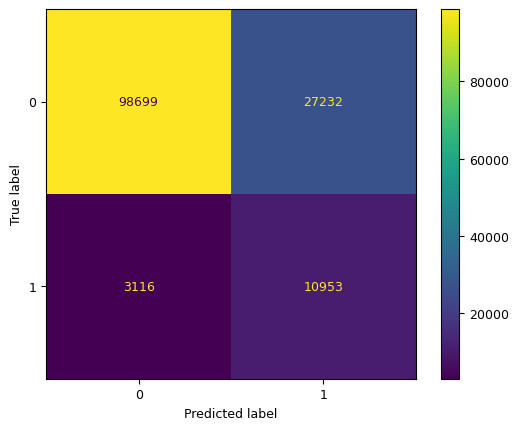

              precision    recall  f1-score   support

           0       0.97      0.78      0.87    125931
           1       0.29      0.78      0.42     14069

    accuracy                           0.78    140000
   macro avg       0.63      0.78      0.64    140000
weighted avg       0.90      0.78      0.82    140000

ROC AUC Score (Primary Objective) - 0.8620337586484635


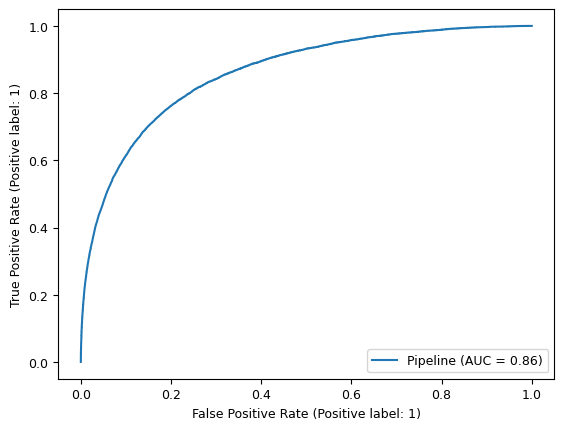

Classification metrics for Valid dataset -
Accuracy - 0.7825
Precision - 0.2856270606911711
Recall - 0.7760451227604512
F1-score - 0.4175667231991431


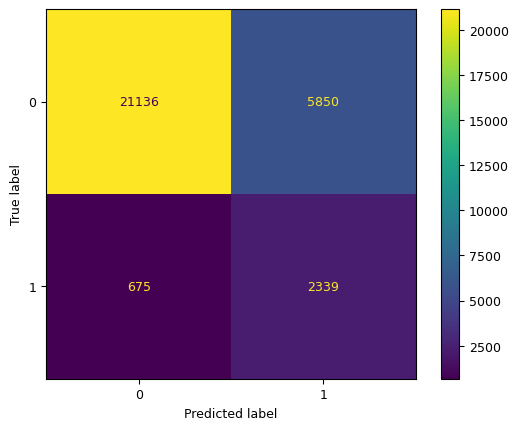

              precision    recall  f1-score   support

           0       0.97      0.78      0.87     26986
           1       0.29      0.78      0.42      3014

    accuracy                           0.78     30000
   macro avg       0.63      0.78      0.64     30000
weighted avg       0.90      0.78      0.82     30000

ROC AUC Score (Primary Objective) - 0.8603474676416797


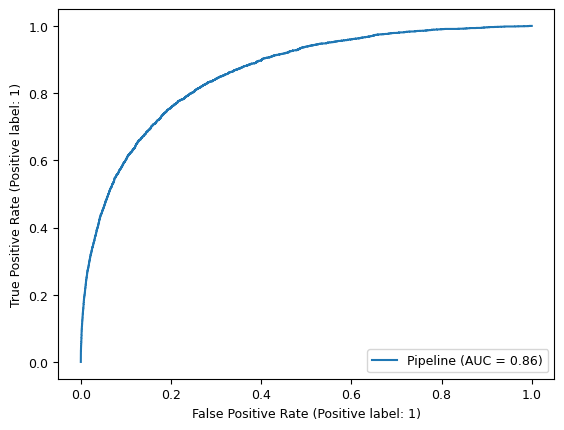

Classification metrics for Test dataset -
Accuracy - 0.7828666666666667
Precision - 0.28525837731680376
Recall - 0.7708126036484245
F1-score - 0.41641282924207135


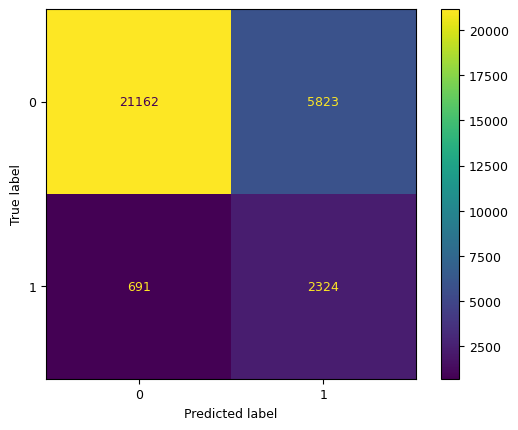

              precision    recall  f1-score   support

           0       0.97      0.78      0.87     26985
           1       0.29      0.77      0.42      3015

    accuracy                           0.78     30000
   macro avg       0.63      0.78      0.64     30000
weighted avg       0.90      0.78      0.82     30000

ROC AUC Score (Primary Objective) - 0.8566890825349505


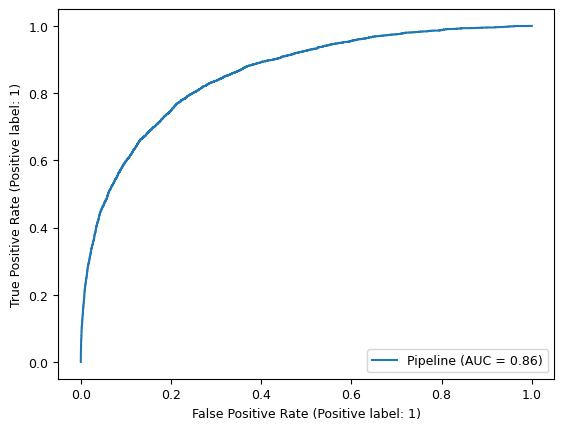

In [31]:
print("Classification metrics for Train dataset -")
classification_metrics(best_lr_clf, train_X_scaled, train_y)

print("Classification metrics for Valid dataset -")
classification_metrics(best_lr_clf, mm_scaler.transform(valid_X), valid_y)

print("Classification metrics for Test dataset -")
classification_metrics(best_lr_clf, mm_scaler.transform(test_X), test_y)


#### SUBMISSION FOR KAGGLE COMPETITION

Submitting the test data prediction for Logistic Regression model on Kaggle Received score of 
- 0.77 on public/private leader board using hard labels of 0, 1
- 0.85 on public/private leader board using probability P(y=1|X)



### Scaled data + LinearSVC/SVC
- We'll be trying out `CalibratedClassifierCV` since we need prob for LinearSVC and it doesn't implicitly provide this
- More about calibration [here](https://scikit-learn.org/stable/modules/calibration.html)
- [Model Calibration](https://www.analyticsvidhya.com/blog/2022/10/calibration-of-machine-learning-models/)


In [32]:
# SVC LinearSVC
# LinearSVC have decision function which is used to separate one class from another
# CalibratedClassifierCV - trains a logistic regression model on the above decision function to get probabilities
svc_clf = CalibratedClassifierCV(
    LinearSVC(dual=False),
    cv=3,
)
svc_clf.fit(train_X_scaled, train_y)


CalibratedClassifierCV(cv=3, estimator=LinearSVC(dual=False))

In [33]:
probs = svc_clf.predict_proba(train_X_scaled)
probs


array([[0.9952085 , 0.0047915 ],
       [0.99768155, 0.00231845],
       [0.9536147 , 0.0463853 ],
       ...,
       [0.95798447, 0.04201553],
       [0.99615188, 0.00384812],
       [0.98941387, 0.01058613]])

In [34]:
# svc_clf.estimator.decision_function(train_X_scaled)

#### Evaluation

Classification metrics for Train dataset -
Accuracy - 0.9150571428571429
Precision - 0.699614890885751
Recall - 0.2711635510697278
F1-score - 0.3908411023460711


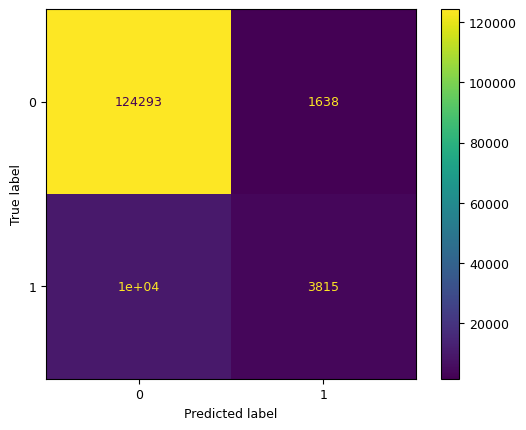

              precision    recall  f1-score   support

           0       0.92      0.99      0.95    125931
           1       0.70      0.27      0.39     14069

    accuracy                           0.92    140000
   macro avg       0.81      0.63      0.67    140000
weighted avg       0.90      0.92      0.90    140000

ROC AUC Score (Primary Objective) - 0.8618262002714523


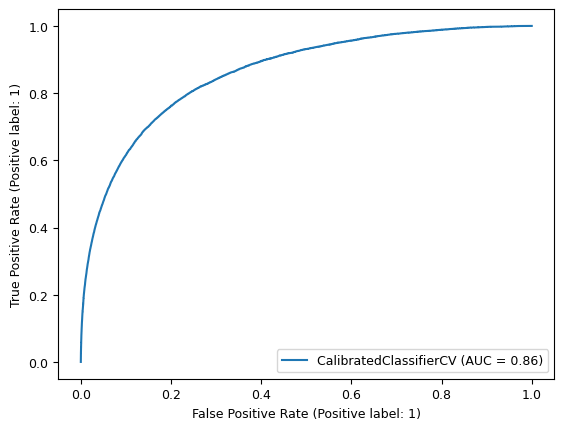

Classification metrics for Valid dataset -
Accuracy - 0.9133666666666667
Precision - 0.6742233417296389
Recall - 0.2664233576642336
F1-score - 0.38192627824019026


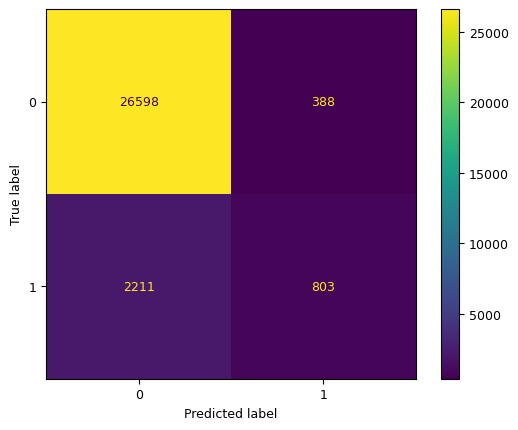

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     26986
           1       0.67      0.27      0.38      3014

    accuracy                           0.91     30000
   macro avg       0.80      0.63      0.67     30000
weighted avg       0.90      0.91      0.90     30000

ROC AUC Score (Primary Objective) - 0.8607685245233453


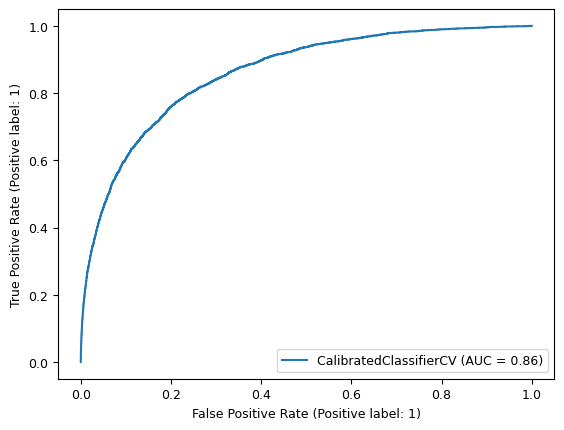

Classification metrics for Test dataset -
Accuracy - 0.9134333333333333
Precision - 0.6882882882882883
Recall - 0.25339966832504146
F1-score - 0.3704242424242424


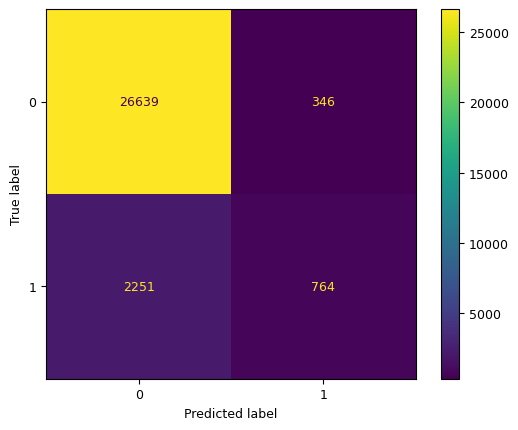

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     26985
           1       0.69      0.25      0.37      3015

    accuracy                           0.91     30000
   macro avg       0.81      0.62      0.66     30000
weighted avg       0.90      0.91      0.89     30000

ROC AUC Score (Primary Objective) - 0.856890545727296


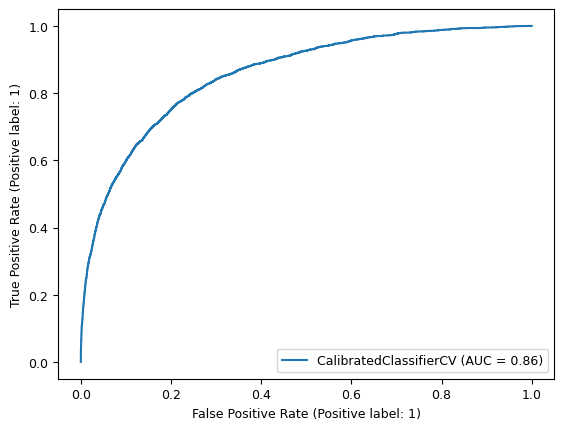

In [35]:
print("Classification metrics for Train dataset -")
classification_metrics(svc_clf, train_X_scaled, train_y)

print("Classification metrics for Valid dataset -")
classification_metrics(svc_clf, mm_scaler.transform(valid_X), valid_y)

print("Classification metrics for Test dataset -")
classification_metrics(svc_clf, mm_scaler.transform(test_X), test_y)


In [36]:
# had already tried with other set grid, takes too long to search
# so skipping directly to best params
param_grid = [
    {
        "l_svc__estimator__class_weight": ["balanced"],
        "l_svc__estimator__max_iter": [2000],  # [1500, 2000, 2500]
        "l_svc__estimator__penalty": ["l2"],  # ["l1", "l2"],
        "l_svc__estimator__C": [0.01],  # [0.01, 0.1, 1, 10]
    }
]

lr_clf_pipline = Pipeline([("l_svc", CalibratedClassifierCV(LinearSVC(dual=False)))])
grid_search = GridSearchCV(
    lr_clf_pipline,
    param_grid,
    cv=3,
    refit=True,
)
grid_search.fit(train_X_scaled, train_y)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('l_svc',
                                        CalibratedClassifierCV(estimator=LinearSVC(dual=False)))]),
             param_grid=[{'l_svc__estimator__C': [0.01],
                          'l_svc__estimator__class_weight': ['balanced'],
                          'l_svc__estimator__max_iter': [2000],
                          'l_svc__estimator__penalty': ['l2']}])

In [37]:
best_svc_clf = grid_search.best_estimator_
best_svc_clf


Pipeline(steps=[('l_svc',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.01,
                                                            class_weight='balanced',
                                                            dual=False,
                                                            max_iter=2000)))])

Classification metrics for Train dataset -
Accuracy - 0.9146714285714286
Precision - 0.6948063864929345
Recall - 0.26910228161205485
F1-score - 0.38794958499846294


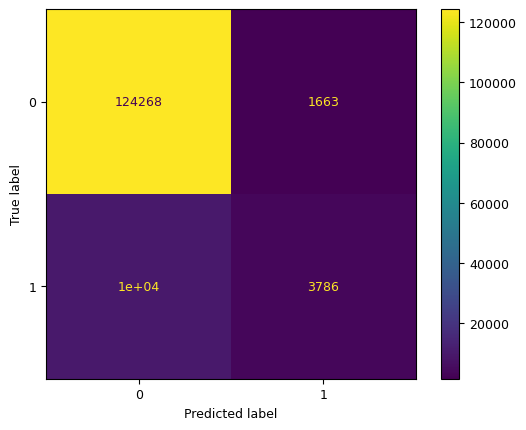

              precision    recall  f1-score   support

           0       0.92      0.99      0.95    125931
           1       0.69      0.27      0.39     14069

    accuracy                           0.91    140000
   macro avg       0.81      0.63      0.67    140000
weighted avg       0.90      0.91      0.90    140000

ROC AUC Score (Primary Objective) - 0.8620366366374674


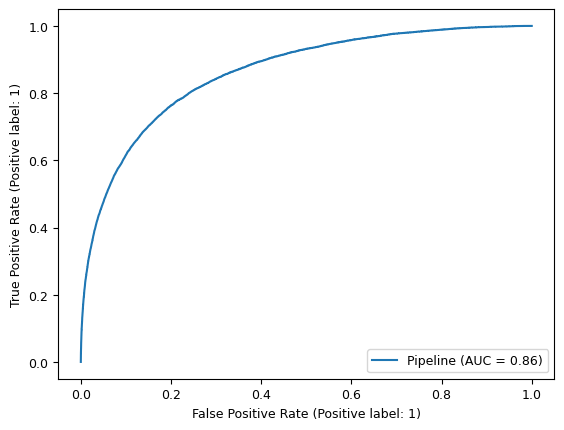

Classification metrics for Valid dataset -
Accuracy - 0.9130666666666667
Precision - 0.6723259762308998
Recall - 0.26277372262773724
F1-score - 0.37786259541984735


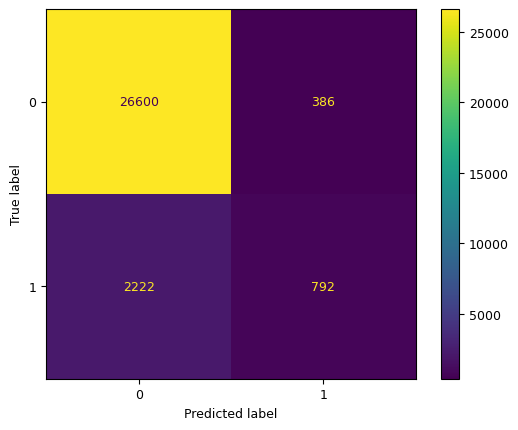

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     26986
           1       0.67      0.26      0.38      3014

    accuracy                           0.91     30000
   macro avg       0.80      0.62      0.67     30000
weighted avg       0.90      0.91      0.90     30000

ROC AUC Score (Primary Objective) - 0.8603815116894892


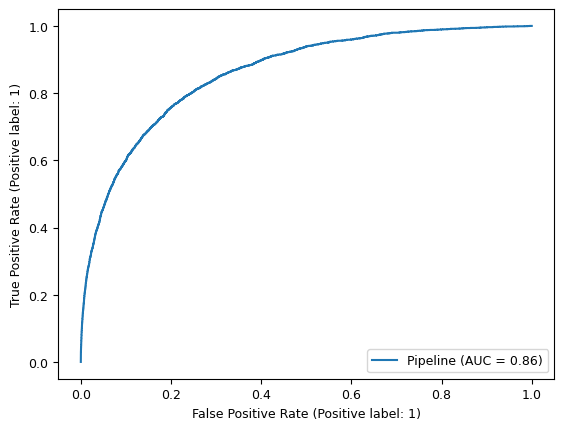

Classification metrics for Test dataset -
Accuracy - 0.9137666666666666
Precision - 0.6927927927927928
Recall - 0.2550580431177446
F1-score - 0.3728484848484848


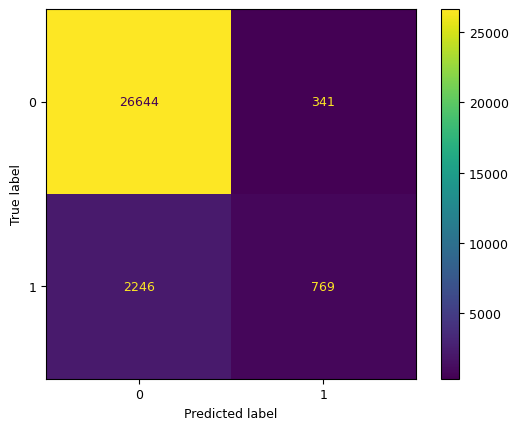

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     26985
           1       0.69      0.26      0.37      3015

    accuracy                           0.91     30000
   macro avg       0.81      0.62      0.66     30000
weighted avg       0.90      0.91      0.90     30000

ROC AUC Score (Primary Objective) - 0.8566346821878502


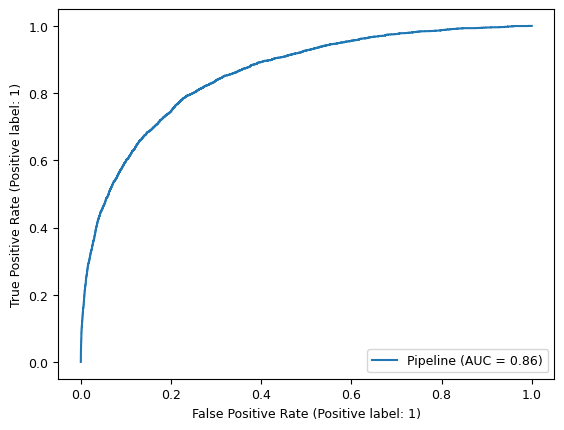

In [38]:
print("Classification metrics for Train dataset -")
classification_metrics(best_svc_clf, train_X_scaled, train_y)

print("Classification metrics for Valid dataset -")
classification_metrics(best_svc_clf, mm_scaler.transform(valid_X), valid_y)

print("Classification metrics for Test dataset -")
classification_metrics(best_svc_clf, mm_scaler.transform(test_X), test_y)


#### SUBMISSION FOR KAGGLE COMPETITION

Submitting the test data prediction for Logistic Regression model on Kaggle Received score of 
- 0.63 on public/private leader board using hard labels of 0, 1
- 0.85 on public/private leader board using probability P(y=1|X)


Other Models/concepts to try - 
- SVC (takes too long and doesn't scale well with data) 
- Boosting Machines
- Ensembles of different models
- Stacking/Blending
- Shallow Neural Network
- Feature Engineering | Ex- PCA dataset + classifier model 
- Rigrous Evaluation using Kfold cross validation -> train on complete dataset